## plan trip with flight search & feedabck for the trip

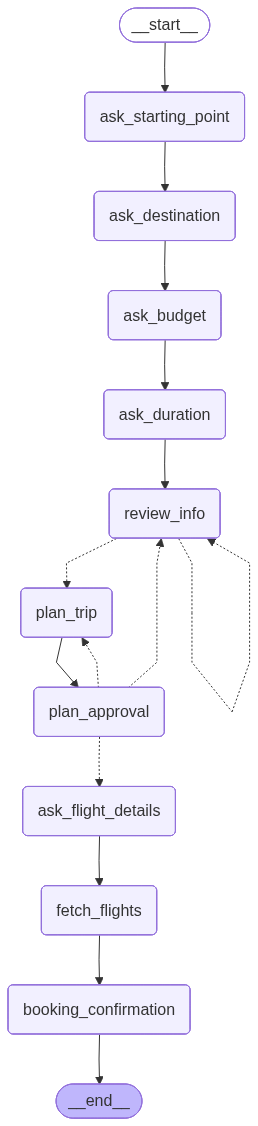

In [3]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langgraph.types import interrupt, Command
import uuid
import os

class TripState(TypedDict):
    starting_point: Optional[str]
    destination: Optional[str]
    budget: Optional[str]
    duration: Optional[str]
    proposed_plan: Optional[str]
    satisfied_with_plan: Optional[bool]
    done: Optional[bool]
    selected_flight: Optional[str]
    flight_source: Optional[str]
    flight_destination: Optional[str]
    flight_date: Optional[str]
    return_trip: Optional[bool]
    available_flights: Optional[list]

def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

llm = get_groq_llm()
FIELDS = ["starting_point", "destination", "budget", "duration"]
FIELD_QS = {
    "starting_point": "Ask the user for their trip starting location in a friendly way.",
    "destination": "Ask the user where they'd like to travel, naturally.",
    "budget": "Ask the user what budget they'd like to set for the trip, friendly and casual.",
    "duration": "Ask, in a conversational style, how many days they want their trip to last."
}

def generate_slot_question(slot_name):
    print("Entering generate_slot_question")
    prompt = FIELD_QS[slot_name]
    response = llm([HumanMessage(content=prompt)]).content.strip()
    print(f"DEBUG: Generated question for '{slot_name}': {response}")
    return response

def extract_slot_value(slot_name, user_input):
    print("Entering extract_slot_value")
    prompt = (
        f"You are a smart assistant filling out a travel form.\n"
        f"The user was asked to specify their '{slot_name.replace('_', ' ')}'.\n"
        f"User replied: \"{user_input}\"\n"
        f"Extract and reply with ONLY the value for '{slot_name}'. If no clear value is found, reply 'None'."
    )
    response = llm([HumanMessage(content=prompt)]).content.strip()
    if response.lower() == "none":
        response = None
    print(f"DEBUG: Extracted value for {slot_name}: '{response}'")
    return response

def extract_change_field(user_input: str) -> Optional[str]:
    print("Entering extract_change_field")
    prompt = (
        "Decide which of these trip fields (if any) the user wants to update: "
        "starting_point, destination, budget, duration.\n"
        f"User said: \"{user_input}\"\n"
        "Reply ONLY with the field name (starting_point, destination, budget, duration) if you detect it, or 'proceed' if approval."
    )
    result = llm([HumanMessage(content=prompt)]).content.strip().lower()
    print(f"DEBUG: LLM slot change extraction: '{result}'")
    for f in FIELDS:
        if f in result:
            return f
    if "proceed" in result or "ok" in result or "yes" in result:
        return "proceed"
    return None

def ask_starting_point(state: TripState) -> TripState:
    print("DEBUG: Entering ask_starting_point with state")
    if not state.get("starting_point"):
        q = generate_slot_question("starting_point")
        user_input = interrupt(q)
        value = extract_slot_value("starting_point", user_input)
        state["starting_point"] = value
    return state

def ask_destination(state: TripState) -> TripState:
    print("DEBUG: Entering ask_destination with state")
    if not state.get("destination"):
        q = generate_slot_question("destination")
        user_input = interrupt(q)
        value = extract_slot_value("destination", user_input)
        state["destination"] = value
    return state

def ask_budget(state: TripState) -> TripState:
    print("DEBUG: Entering ask_budget with state")
    if not state.get("budget"):
        q = generate_slot_question("budget")
        user_input = interrupt(q)
        value = extract_slot_value("budget", user_input)
        state["budget"] = value
    return state

def ask_duration(state: TripState) -> TripState:
    print("DEBUG: Entering ask_duration with state")
    if not state.get("duration"):
        q = generate_slot_question("duration")
        user_input = interrupt(q)
        value = extract_slot_value("duration", user_input)
        state["duration"] = value
    return state

def review_info(state: TripState) -> TripState:
    print("DEBUG: Entering review_info with state", state)
    summary = (
        f"Please review your trip details:\n"
        f"- Starting point: {state['starting_point']}\n"
        f"- Destination: {state['destination']}\n"
        f"- Budget: {state['budget']}\n"
        f"- Duration: {state['duration']}\n"
        "Reply 'proceed' to confirm, or naturally say what you'd like to change."
    )
    answer = interrupt(summary)
    print(f"DEBUG: Got answer for review: {answer}")
    change_field = extract_change_field(answer)
    print(f"DEBUG: type of change_field: {type(change_field)}")
    print(f"DEBUG: LLM extracted in review_info: {change_field}")
    
    if change_field == "proceed":
        return state
    elif change_field in FIELDS:
        state[change_field] = None
        # Defensive: reset plan approval flag so approval loop is always clean
        state['satisfied_with_plan'] = None
        return state
    else:
        print("DEBUG: Could not parse field to change; ask again.")
        return review_info(state)

def review_router(state: TripState):
    print("DEBUG: In review_router with state", state)
    missing = [fld for fld in FIELDS if not state.get(fld)]
    print(f"DEBUG: In review_router, missing fields: {missing}")
    if len(missing)>0:
        return "review_info"
    return "plan_trip"

def plan_trip(state: TripState) -> TripState:
    print("DEBUG: Entering plan_trip with state", state)
    # Defensive: always reset approval flag before generating a new plan
    state['satisfied_with_plan'] = None
    prompt = (
        f"Can you plan a fun, friendly, {state['duration']}-day itinerary from {state['starting_point']} "
        f"to {state['destination']} with a budget of {state['budget']}?"
    )
    result = llm([HumanMessage(content=prompt)])
    print(f"\nYour itinerary:\n{result.content}\n")
    state['proposed_plan'] = result.content
    return state

def plan_approval(state: TripState) -> TripState:
    print("DEBUG: Entering plan_approval with state", state)
    review = (
        f"Here’s your trip plan:\n\n{state.get('proposed_plan','none')}\n\n"
        "Are you satisfied? Type 'yes' to book flights, or request changes."
    )
    user_input = interrupt(review)
    change_field = extract_change_field(user_input)
    print("DEBUG: LLM approval/feedback extraction:", change_field)
    print(f"DEBUG: type of change_field: {type(change_field)}")
    print(f"DEBUG: LLM extracted in plan_approval: {change_field}")
    if change_field == "proceed":
        state['satisfied_with_plan'] = True
    elif change_field in FIELDS:
        state[change_field] = None
        state['satisfied_with_plan'] = None
    else:
        state['satisfied_with_plan'] = None
    return state

def plan_approval_router(state: TripState):
    print(f"DEBUG: In plan_approval_router, satisfied_with_plan={state.get('satisfied_with_plan')}")
    if state.get("satisfied_with_plan"):
        print("DEBUG: Plan approved; moving to flight booking.")
        return "ask_flight_details"
    missing = [fld for fld in FIELDS if not state.get(fld)]
    if len(missing)>0:
        print(f"DEBUG: Editing slot(s) {missing}; will re-review.")
        return "review_info"
    print("DEBUG: General feedback; re-planning.")
    return "plan_trip"

def ask_flight_details(state: TripState) -> TripState:
    print("DEBUG: Entering ask_flight_details with state", state)
    src = interrupt(f"To book your flight, please confirm your departure city (or edit): [{state['starting_point']}]")
    dst = interrupt(f"And your arrival city? [{state['destination']}]")
    date = interrupt("On what date would you like to depart? (YYYY-MM-DD)")
    ret_type = interrupt("Is this a one-way or round-trip? (Type 'one-way' or 'round-trip')")
    state['flight_source'] = src or state['starting_point']
    state['flight_destination'] = dst or state['destination']
    state['flight_date'] = date
    state['return_trip'] = "round" in ret_type.lower()
    return state

def fetch_flights(state: TripState) -> TripState:
    print(f"DEBUG: Fetching flights {state['flight_source']} → {state['flight_destination']} on {state['flight_date']} (return: {state['return_trip']})")
    # Simulate options for DEMO
    state['available_flights'] = [
        "AI101 | 8:00-10:30 | ₹6,300",
        "6E205 | 12:10-14:30 | ₹5,950",
        "G8 302 | 18:45-21:15 | ₹6,010"
    ]
    opts = "\n".join([f"{i+1}. {f}" for i, f in enumerate(state['available_flights'])])
    sel = interrupt(f"Here are some flight options:\n{opts}\nSelect a flight number:")
    try:
        ix = int(sel) - 1
        state['selected_flight'] = state['available_flights'][ix]
        print(f"DEBUG: User selected flight: {state['selected_flight']}")
    except Exception:
        state['selected_flight'] = None
        print("DEBUG: Invalid flight selection!")
    return state

def booking_confirmation(state: TripState) -> TripState:
    print("DEBUG: Entering booking_confirmation with state", state)
    if state.get("selected_flight"):
        print(f"\nBooking confirmed for: {state['selected_flight']}")
        state['done'] = True
    else:
        print("No flight selected. Ending flow.")
        state['done'] = True
    return state

graph = StateGraph(TripState)
graph.add_node("ask_starting_point", ask_starting_point)
graph.add_node("ask_destination", ask_destination)
graph.add_node("ask_budget", ask_budget)
graph.add_node("ask_duration", ask_duration)
graph.add_node("review_info", review_info)
graph.add_node("plan_trip", plan_trip)
graph.add_node("plan_approval", plan_approval)
graph.add_node("ask_flight_details", ask_flight_details)
graph.add_node("fetch_flights", fetch_flights)
graph.add_node("booking_confirmation", booking_confirmation)

graph.set_entry_point("ask_starting_point")
graph.add_edge("ask_starting_point", "ask_destination")
graph.add_edge("ask_destination", "ask_budget")
graph.add_edge("ask_budget", "ask_duration")
graph.add_edge("ask_duration", "review_info")
graph.add_conditional_edges(
    "review_info", review_router, {"review_info": "review_info", "plan_trip": "plan_trip"}
)
graph.add_edge("plan_trip", "plan_approval")
graph.add_conditional_edges(
    "plan_approval", plan_approval_router,
    {
        "plan_trip": "plan_trip",
        "ask_flight_details": "ask_flight_details",
        "review_info": "review_info"
    }
)
graph.add_edge("ask_flight_details", "fetch_flights")
graph.add_edge("fetch_flights", "booking_confirmation")
graph.add_edge("booking_confirmation", END)

checkpointer = MemorySaver()
workflow = graph.compile(checkpointer=checkpointer)




from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)



In [4]:

THREAD_ID = str(uuid.uuid4())
config = {"configurable": {"thread_id": THREAD_ID}}
state = {}
print("Bot: Hi there! Let's plan your trip together.")

while True:
    result = workflow.invoke(state, config)
    print(f"DEBUG State: {state}")
    print(f"DEBUG Result: {result}")

    if result.get("done"):
        print("-- Trip planning complete! --")
        break

    if "__interrupt__" in result:
        prompt = result["__interrupt__"][0].value
        user_input = input(prompt + " ")
        state = workflow.invoke(Command(resume=user_input), config)
        continue

    print("DEBUG: Workflow reached END, exiting.")
    break


Bot: Hi there! Let's plan your trip together.
DEBUG: Entering ask_starting_point with state
Entering generate_slot_question
DEBUG: Generated question for 'starting_point': Sure thing! Where are you starting your trip from? 🌍
DEBUG State: {}
DEBUG Result: {'__interrupt__': [Interrupt(value='Sure thing! Where are you starting your trip from? 🌍', id='0bf0a96bed72890afea9bafb3d999605')]}
DEBUG: Entering ask_starting_point with state
Entering generate_slot_question
DEBUG: Generated question for 'starting_point': Sure thing! Where are you starting your trip from? 🚗✈️
Entering extract_slot_value
DEBUG: Extracted value for starting_point: 'mumbai'
DEBUG: Entering ask_destination with state
Entering generate_slot_question
DEBUG: Generated question for 'destination': Sure thing! Where would you like to travel? 🌍✈️
DEBUG: Entering ask_starting_point with state
DEBUG: Entering ask_destination with state
Entering generate_slot_question
DEBUG: Generated question for 'destination': Where would you li

KeyboardInterrupt: Interrupted by user

## 2nd attempt

In [ ]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langgraph.types import interrupt, Command
import uuid
import os

class TripState(TypedDict):
    starting_point: Optional[str]
    destination: Optional[str]
    budget: Optional[str]
    duration: Optional[str]
    proposed_plan: Optional[str]
    satisfied_with_plan: Optional[bool]
    done: Optional[bool]
    selected_flight: Optional[str]
    flight_source: Optional[str]
    flight_destination: Optional[str]
    flight_date: Optional[str]
    return_trip: Optional[bool]
    available_flights: Optional[list]



c:\Users\smm931389\Desktop\RAG_patterns\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

llm = get_groq_llm()
FIELDS = ["starting_point", "destination", "budget", "duration"]
FIELD_QS = {
    "starting_point": "Ask the user for their trip starting location in a friendly way.",
    "destination": "Ask the user where they'd like to travel, naturally.",
    "budget": "Ask the user what budget they'd like to set for the trip, friendly and casual.",
    "duration": "Ask, in a conversational style, how many days they want their trip to last."
}

def generate_slot_question(slot_name):
    print("DEBUG: Entering generate_slot_question()")
    prompt = FIELD_QS[slot_name]
    response = llm([HumanMessage(content=prompt)]).content.strip()
    print(f"DEBUG: Generated question for '{slot_name}': {response}")
    return response

def extract_slot_value(slot_name, user_input):
    print("DEBUG: Entering extract_slot_value()")
    prompt = (
        f"You are a smart assistant filling out a travel form.\n"
        f"The user was asked to specify their '{slot_name.replace('_', ' ')}'.\n"
        f"User replied: \"{user_input}\"\n"
        f"Extract and reply with ONLY the value for '{slot_name}'. If no clear value is found, reply 'None'."
    )
    response = llm([HumanMessage(content=prompt)]).content.strip()
    if response.lower() == "none":
        response = None
    print(f"DEBUG: Extracted value for {slot_name}: '{response}'")
    return response

def extract_change_field(user_input: str) -> Optional[str]:
    """
    Detect which trip field (if any) the user wants to change, or if they want to proceed.
    Uses LLM for fuzzy detection, but is tolerant of natural human responses.
    """
    user_text = user_input.strip().lower()

    # --- Fast direct checks (no LLM call for simple confirmations) ---
    if any(word in user_text for word in ["proceed", "ok", "okay", "yes", "continue", "done", "confirm", "next", "go ahead", "move on"]):
        print("DEBUG: Direct 'proceed' detected without LLM.")
        return "proceed"

    # --- LLM fallback for detecting slot-change intent ---
    prompt = (
        "Decide which of these trip fields (if any) the user wants to update: "
        "starting_point, destination, budget, duration.\n"
        f"User said: \"{user_input}\"\n"
        "Reply ONLY with one of these: starting_point, destination, budget, duration, or 'proceed' if the user seems to approve or confirm."
    )

    try:
        result = llm([HumanMessage(content=prompt)]).content.strip().lower()
    except Exception as e:
        print(f"DEBUG: extract_change_field LLM error: {e}")
        return None

    print(f"DEBUG: LLM slot change extraction: '{result}'")

    # --- Interpret LLM output robustly ---
    for f in FIELDS:
        if f in result:
            return f
    if any(word in result for word in ["proceed", "ok", "okay", "yes", "continue", "done", "confirm", "next"]):
        return "proceed"

    return None


def ask_starting_point(state: TripState) -> TripState:
    print("DEBUG: Entering ask_starting_point with state")
    if not state.get("starting_point"):
        q = generate_slot_question("starting_point")
        user_input = interrupt(q)
        value = extract_slot_value("starting_point", user_input)
        state["starting_point"] = value
    return state

def ask_destination(state: TripState) -> TripState:
    print("DEBUG: Entering ask_destination with state")
    if not state.get("destination"):
        q = generate_slot_question("destination")
        user_input = interrupt(q)
        value = extract_slot_value("destination", user_input)
        state["destination"] = value
    return state

def ask_budget(state: TripState) -> TripState:
    print("DEBUG: Entering ask_budget with state")
    if not state.get("budget"):
        q = generate_slot_question("budget")
        user_input = interrupt(q)
        value = extract_slot_value("budget", user_input)
        state["budget"] = value
    return state

def ask_duration(state: TripState) -> TripState:
    print("DEBUG: Entering ask_duration with state")
    if not state.get("duration"):
        q = generate_slot_question("duration")
        user_input = interrupt(q)
        value = extract_slot_value("duration", user_input)
        state["duration"] = value
    return state

def review_info(state: TripState) -> TripState:
    """
    Present current trip details, let user confirm or specify changes.
    """
    print("DEBUG: Entering review_info with state", state)

    summary = (
        f"Please review your trip details:\n"
        f"- Starting point: {state['starting_point']}\n"
        f"- Destination: {state['destination']}\n"
        f"- Budget: {state['budget']}\n"
        f"- Duration: {state['duration']}\n"
        "Reply 'proceed' to confirm, or say naturally what you'd like to change."
    )

    user_input = interrupt(summary)
    user_text = user_input.strip().lower()

    # --- Direct confirmation bypass (no LLM needed) ---
    if any(x in user_text for x in ["proceed", "ok", "okay", "yes", "continue", "done", "confirm", "next", "go ahead"]):
        print("DEBUG: Direct confirmation detected in review_info.")
        return state

    # --- Otherwise, let LLM detect if user mentioned a specific field to change ---
    change_field = extract_change_field(user_input)
    print(f"DEBUG: type of change_field: {type(change_field)}")
    print(f"DEBUG: LLM extracted in review_info: {change_field}")

    if change_field == "proceed":
        print("DEBUG: LLM confirmed proceed.")
        return state
    elif change_field in FIELDS:
        print(f"DEBUG: LLM detected change request for field '{change_field}', resetting it.")
        state[change_field] = None
        state['satisfied_with_plan'] = None
        return state
    else:
        print("DEBUG: Could not interpret response, re-asking review.")
        # Prevent infinite recursion — only re-ask once
        reask = interrupt("Sorry, I didn’t catch that. Would you like to proceed or change something?")
        if any(x in reask.lower() for x in ["proceed", "ok", "yes", "continue"]):
            return state
        return review_info(state)


def review_router(state: TripState):
    print("DEBUG: In review_router with state", state)
    missing = [fld for fld in FIELDS if not state.get(fld)]
    print(f"DEBUG: In review_router, missing fields: {missing}")
    if len(missing) > 0:
        return "review_info"
    return "plan_trip"

def plan_trip(state: TripState) -> TripState:
    print("DEBUG: Entering plan_trip with state", state)
    state['satisfied_with_plan'] = None
    prompt = (
        f"Can you plan a fun, friendly, {state['duration']}-day itinerary from {state['starting_point']} "
        f"to {state['destination']} with a budget of {state['budget']}?"
    )
    result = llm([HumanMessage(content=prompt)])
    print(f"\nYour itinerary:\n{result.content}\n")
    state['proposed_plan'] = result.content
    return state

def plan_approval(state: TripState) -> TripState:
    print("DEBUG1: Entering plan_approval with state", state)
    review = (
        f"Here’s your trip plan:\n\n{state.get('proposed_plan','none')}\n\n"
        "Are you satisfied? Type 'yes', 'proceed', or 'ok' to book flights, or request changes."
    )
    user_input = interrupt(review)
    print(f"DEBUG2: User input in approval: {user_input!r}")
    change_field = extract_change_field(user_input)
    print(f"DEBUG: LLM approval extraction: {change_field!r}")
    if change_field in ("proceed", "yes", "ok"):
        state['satisfied_with_plan'] = True
    elif change_field in FIELDS:
        state[change_field] = None
        state['satisfied_with_plan'] = None
    else:
        # For anything else, also check if user's direct text is "yes"/etc for robustness
        if user_input.strip().lower() in ("proceed", "yes", "ok"):
            state['satisfied_with_plan'] = True
        else:
            state['satisfied_with_plan'] = None
    return state


def plan_approval_router(state: TripState):
    print(f"DEBUG: In plan_approval_router, satisfied_with_plan={state.get('satisfied_with_plan')}")
    if state.get("satisfied_with_plan"):
        print("DEBUG: Plan approved; moving to flight booking.")
        return "ask_flight_details"
    missing = [fld for fld in FIELDS if not state.get(fld)]
    if missing:
        print(f"DEBUG: Editing slot(s) {missing}; will re-review.")
        return "review_info"
    print("DEBUG: General feedback; re-planning.")
    return "plan_trip"


def ask_flight_details(state: TripState) -> TripState:
    print("DEBUG: Entering ask_flight_details with state", state)
    src = interrupt(f"To book your flight, please confirm your departure city (or edit): [{state['starting_point']}]")
    dst = interrupt(f"And your arrival city? [{state['destination']}]")
    date = interrupt("On what date would you like to depart? (YYYY-MM-DD)")
    ret_type = interrupt("Is this a one-way or round-trip? (Type 'one-way' or 'round-trip')")
    state['flight_source'] = src or state['starting_point']
    state['flight_destination'] = dst or state['destination']
    state['flight_date'] = date
    state['return_trip'] = "round" in ret_type.lower()
    return state

def fetch_flights(state: TripState) -> TripState:
    print(f"DEBUG: Fetching flights {state['flight_source']} → {state['flight_destination']} on {state['flight_date']} (return: {state['return_trip']})")
    state['available_flights'] = [
        "AI101 | 8:00-10:30 | ₹6,300",
        "6E205 | 12:10-14:30 | ₹5,950",
        "G8 302 | 18:45-21:15 | ₹6,010"
    ]
    opts = "\n".join([f"{i+1}. {f}" for i, f in enumerate(state['available_flights'])])
    sel = interrupt(f"Here are some flight options:\n{opts}\nSelect a flight number:")
    try:
        ix = int(sel) - 1
        state['selected_flight'] = state['available_flights'][ix]
        print(f"DEBUG: User selected flight: {state['selected_flight']}")
    except Exception:
        state['selected_flight'] = None
        print("DEBUG: Invalid flight selection!")
    return state

def booking_confirmation(state: TripState) -> TripState:
    print("DEBUG: Entering booking_confirmation with state", state)
    if state.get("selected_flight"):
        print(f"\nBooking confirmed for: {state['selected_flight']}")
        state['done'] = True
    else:
        print("No flight selected. Ending flow.")
        state['done'] = True
    return state








In [ ]:
graph = StateGraph(TripState)
graph.add_node("ask_starting_point", ask_starting_point)
graph.add_node("ask_destination", ask_destination)
graph.add_node("ask_budget", ask_budget)
graph.add_node("ask_duration", ask_duration)
graph.add_node("review_info", review_info)
graph.add_node("plan_trip", plan_trip)
graph.add_node("plan_approval", plan_approval)
graph.add_node("ask_flight_details", ask_flight_details)
graph.add_node("fetch_flights", fetch_flights)
graph.add_node("booking_confirmation", booking_confirmation)

graph.set_entry_point("ask_starting_point")
graph.add_edge("ask_starting_point", "ask_destination")
graph.add_edge("ask_destination", "ask_budget")
graph.add_edge("ask_budget", "ask_duration")
graph.add_edge("ask_duration", "review_info")
graph.add_conditional_edges(
    "review_info", review_router, {"review_info": "review_info", "plan_trip": "plan_trip"}
)
graph.add_edge("plan_trip", "plan_approval")
graph.add_conditional_edges(
    "plan_approval", plan_approval_router,
    {
        "plan_trip": "plan_trip",
        "ask_flight_details": "ask_flight_details",
        "review_info": "review_info"
    }
)
graph.add_edge("ask_flight_details", "fetch_flights")
graph.add_edge("fetch_flights", "booking_confirmation")
graph.add_edge("booking_confirmation", END)


In [2]:
checkpointer = MemorySaver()
workflow = graph.compile(checkpointer=checkpointer)

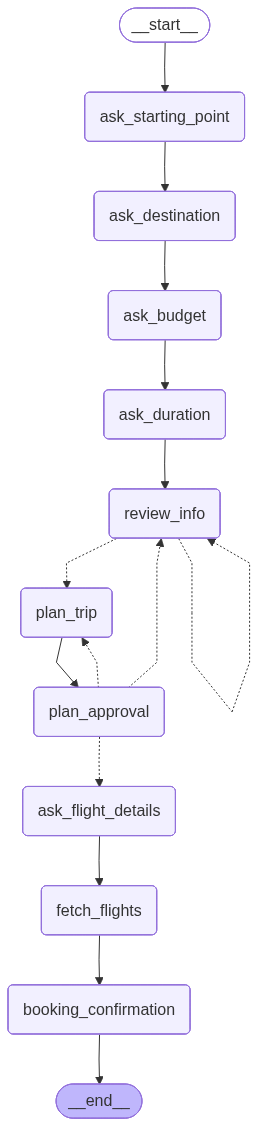

In [3]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [4]:
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}
state = {}

result = workflow.invoke(state, config)
while True:
    if "__interrupt__" in result:
        user_input = input(result["__interrupt__"][0].value + " ")
        result = workflow.invoke(Command(resume=user_input), config)
        continue

    if result.get("done"):
        print("Trip complete!")
        break





DEBUG: Entering ask_starting_point with state
DEBUG: Entering generate_slot_question()


C:\Users\smm931389\AppData\Local\Temp\ipykernel_85396\622651745.py:45: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([HumanMessage(content=prompt)]).content.strip()


DEBUG: Generated question for 'starting_point': Hey there! Where are you starting your trip from? 🚗✈️
DEBUG: Entering ask_starting_point with state
DEBUG: Entering generate_slot_question()
DEBUG: Generated question for 'starting_point': Sure thing! Where are you starting your adventure from? 🌍✨
DEBUG: Entering extract_slot_value()
DEBUG: Extracted value for starting_point: 'Mumbai'
DEBUG: Entering ask_destination with state
DEBUG: Entering generate_slot_question()
DEBUG: Generated question for 'destination': Hey! Where are you dreaming of traveling to next? 🌍✈️
DEBUG: Entering ask_destination with state
DEBUG: Entering generate_slot_question()
DEBUG: Generated question for 'destination': Sounds exciting! Where would you love to travel to? 🌍✈️
DEBUG: Entering extract_slot_value()
DEBUG: Extracted value for destination: 'Goa'
DEBUG: Entering ask_budget with state
DEBUG: Entering generate_slot_question()
DEBUG: Generated question for 'budget': Hey, just so I can tailor everything to fit y

KeyboardInterrupt: 

In [5]:
## Amadeus Flight Booking API Key

## Amadeus Flight Booking API Key

In [16]:
from amadeus import Client, ResponseError

amadeus = Client(
    client_id='KgeffAkQczdA54mPqowbiGMPY1whS1AV',
    client_secret='8c69kbUlHM2LBF3l'
)

try:
    response = amadeus.shopping.flight_offers_search.get(
        originLocationCode='BOM',
        destinationLocationCode='CCU',
        departureDate='2025-12-10',
        adults=1)
    print(response.data)
except ResponseError as error:
    print(error)

[{'type': 'flight-offer', 'id': '1', 'source': 'GDS', 'instantTicketingRequired': False, 'nonHomogeneous': False, 'oneWay': False, 'isUpsellOffer': False, 'lastTicketingDate': '2025-12-05', 'lastTicketingDateTime': '2025-12-05', 'numberOfBookableSeats': 9, 'itineraries': [{'duration': 'PT2H40M', 'segments': [{'departure': {'iataCode': 'BOM', 'terminal': '2', 'at': '2025-12-10T06:50:00'}, 'arrival': {'iataCode': 'CCU', 'at': '2025-12-10T09:30:00'}, 'carrierCode': 'AI', 'number': '2771', 'aircraft': {'code': '32N'}, 'operating': {'carrierCode': 'AI'}, 'duration': 'PT2H40M', 'id': '70', 'numberOfStops': 0, 'blacklistedInEU': False}]}], 'price': {'currency': 'EUR', 'total': '68.94', 'base': '60.00', 'fees': [{'amount': '0.00', 'type': 'SUPPLIER'}, {'amount': '0.00', 'type': 'TICKETING'}], 'grandTotal': '68.94'}, 'pricingOptions': {'fareType': ['PUBLISHED'], 'includedCheckedBagsOnly': True}, 'validatingAirlineCodes': ['AI'], 'travelerPricings': [{'travelerId': '1', 'fareOption': 'STANDARD',

In [17]:
for offer in response.data:
    print(f"Flight Offer: {offer['id']}, Price: {offer['price']['total']} {offer['price']['currency']}")

Flight Offer: 1, Price: 68.94 EUR
Flight Offer: 2, Price: 68.94 EUR
Flight Offer: 3, Price: 68.94 EUR
Flight Offer: 4, Price: 73.14 EUR
Flight Offer: 5, Price: 73.14 EUR
Flight Offer: 6, Price: 110.55 EUR
Flight Offer: 7, Price: 110.55 EUR
Flight Offer: 8, Price: 127.25 EUR
Flight Offer: 9, Price: 137.85 EUR
Flight Offer: 10, Price: 140.22 EUR
Flight Offer: 11, Price: 141.00 EUR
Flight Offer: 12, Price: 141.00 EUR
Flight Offer: 13, Price: 143.10 EUR
Flight Offer: 14, Price: 144.15 EUR
Flight Offer: 15, Price: 144.15 EUR
Flight Offer: 16, Price: 144.15 EUR
Flight Offer: 17, Price: 145.20 EUR
Flight Offer: 18, Price: 145.20 EUR
Flight Offer: 19, Price: 146.25 EUR
Flight Offer: 20, Price: 146.25 EUR
Flight Offer: 21, Price: 146.25 EUR
Flight Offer: 22, Price: 146.25 EUR
Flight Offer: 23, Price: 158.85 EUR
Flight Offer: 24, Price: 162.00 EUR
Flight Offer: 25, Price: 162.00 EUR
Flight Offer: 26, Price: 162.00 EUR
Flight Offer: 27, Price: 163.05 EUR
Flight Offer: 28, Price: 164.10 EUR
Flight

## with real flight booking API

In [13]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langgraph.types import interrupt, Command
from amadeus import Client, ResponseError
import uuid
import os

class TripState(TypedDict):
    starting_point: Optional[str]
    destination: Optional[str]
    budget: Optional[str]
    duration: Optional[str]
    proposed_plan: Optional[str]
    satisfied_with_plan: Optional[bool]
    done: Optional[bool]
    selected_flight: Optional[str]
    flight_source: Optional[str]
    flight_destination: Optional[str]
    flight_date: Optional[str]
    return_trip: Optional[bool]
    available_flights: Optional[list]

amadeus = Client(
    client_id=os.getenv("AMADEUS_CLIENT_ID") or "YOUR_CLIENT_ID",
    client_secret=os.getenv("AMADEUS_CLIENT_SECRET") or "YOUR_CLIENT_SECRET"
)


def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

llm = get_groq_llm()
FIELDS = ["starting_point", "destination", "budget", "duration"]
FIELD_QS = {
    "starting_point": "Ask the user for their trip starting location in a friendly way.",
    "destination": "Ask the user where they'd like to travel, naturally.",
    "budget": "Ask the user what budget they'd like to set for the trip, friendly and casual.",
    "duration": "Ask, in a conversational style, how many days they want their trip to last."
}

def generate_slot_question(slot_name):
    print("DEBUG: Entering generate_slot_question()")
    prompt = FIELD_QS[slot_name]
    response = llm([HumanMessage(content=prompt)]).content.strip()
    print(f"DEBUG: Generated question for '{slot_name}': {response}")
    return response

def extract_slot_value(slot_name, user_input):
    print("DEBUG: Entering extract_slot_value()")
    prompt = (
        f"You are a smart assistant filling out a travel form.\n"
        f"The user was asked to specify their '{slot_name.replace('_', ' ')}'.\n"
        f"User replied: \"{user_input}\"\n"
        f"Extract and reply with ONLY the value for '{slot_name}'. If no clear value is found, reply 'None'."
    )
    response = llm([HumanMessage(content=prompt)]).content.strip()
    if response.lower() == "none":
        response = None
    print(f"DEBUG: Extracted value for {slot_name}: '{response}'")
    return response

def extract_change_field(user_input: str) -> Optional[str]:
    """
    Detect which trip field (if any) the user wants to change, or if they want to proceed.
    Uses LLM for fuzzy detection, but is tolerant of natural human responses.
    """
    user_text = user_input.strip().lower()

    # --- Fast direct checks (no LLM call for simple confirmations) ---
    if any(word in user_text for word in ["proceed", "ok", "okay", "yes", "continue", "done", "confirm", "next", "go ahead", "move on"]):
        print("DEBUG: Direct 'proceed' detected without LLM.")
        return "proceed"

    # --- LLM fallback for detecting slot-change intent ---
    prompt = (
        "Decide which of these trip fields (if any) the user wants to update: "
        "starting_point, destination, budget, duration.\n"
        f"User said: \"{user_input}\"\n"
        "Reply ONLY with one of these: starting_point, destination, budget, duration, or 'proceed' if the user seems to approve or confirm."
    )

    try:
        result = llm([HumanMessage(content=prompt)]).content.strip().lower()
    except Exception as e:
        print(f"DEBUG: extract_change_field LLM error: {e}")
        return None

    print(f"DEBUG: LLM slot change extraction: '{result}'")

    # --- Interpret LLM output robustly ---
    for f in FIELDS:
        if f in result:
            return f
    if any(word in result for word in ["proceed", "ok", "okay", "yes", "continue", "done", "confirm", "next"]):
        return "proceed"

    return None


def ask_starting_point(state: TripState) -> TripState:
    print("DEBUG: Entering ask_starting_point with state")
    if not state.get("starting_point"):
        q = generate_slot_question("starting_point")
        user_input = interrupt(q)
        value = extract_slot_value("starting_point", user_input)
        state["starting_point"] = value
    return state

def ask_destination(state: TripState) -> TripState:
    print("DEBUG: Entering ask_destination with state")
    if not state.get("destination"):
        q = generate_slot_question("destination")
        user_input = interrupt(q)
        value = extract_slot_value("destination", user_input)
        state["destination"] = value
    return state

def ask_budget(state: TripState) -> TripState:
    print("DEBUG: Entering ask_budget with state")
    if not state.get("budget"):
        q = generate_slot_question("budget")
        user_input = interrupt(q)
        value = extract_slot_value("budget", user_input)
        state["budget"] = value
    return state

def ask_duration(state: TripState) -> TripState:
    print("DEBUG: Entering ask_duration with state")
    if not state.get("duration"):
        q = generate_slot_question("duration")
        user_input = interrupt(q)
        value = extract_slot_value("duration", user_input)
        state["duration"] = value
    return state

def review_info(state: TripState) -> TripState:
    print("DEBUG: Entering review_info with state", state)

    # Step 1. Build and show summary
    summary = (
        f"Please review your trip details:\n"
        f"- Starting point: {state.get('starting_point')}\n"
        f"- Destination: {state.get('destination')}\n"
        f"- Budget: {state.get('budget')}\n"
        f"- Duration: {state.get('duration')}\n"
        "Reply 'proceed' to confirm, or say what you'd like to change (e.g. 'change budget to 50k')."
    )

    # Step 2. Get user response
    user_input = interrupt(summary)
    user_text = user_input.strip().lower()

    # Step 3. If user confirms, exit review
    if any(x in user_text for x in ["proceed", "ok", "okay", "yes", "continue", "done", "confirm", "next", "go ahead"]):
        print("DEBUG: Direct confirmation detected. Proceeding to next step.")
        return state  # ✅ confirmed

    # Step 4. Detect which field they want to change
    change_field = extract_change_field(user_input)
    print(f"DEBUG: Field to change detected: {change_field}")

    # Step 5. Handle field update
    if change_field in FIELDS:
        ask_prompt = f"Sure! What should be the new {change_field.replace('_',' ')}?"
        new_value_input = interrupt(ask_prompt)
        new_value = extract_slot_value(change_field, new_value_input)
        state[change_field] = new_value
        print(f"DEBUG: Updated {change_field} → {new_value}")

        # ✅ After updating, re-enter review to show updated summary
        return review_info(state)

    # Step 6. If unclear, gently re-ask
    reask = interrupt("Sorry, I didn’t catch that. Would you like to proceed or update something?")
    if any(x in reask.lower() for x in ["proceed", "ok", "yes", "continue"]):
        return state

    return review_info(state)  # ✅ loop back again




def review_router(state: TripState):
    print("DEBUG: In review_router with state", state)
    missing = [fld for fld in FIELDS if not state.get(fld)]
    print(f"DEBUG: In review_router, missing fields: {missing}")
    if len(missing) > 0:
        return "review_info"
    return "plan_trip"

def plan_trip(state: TripState) -> TripState:
    print("DEBUG: Entering plan_trip with state", state)
    state['satisfied_with_plan'] = None
    prompt = (
        f"Can you plan a fun, friendly, {state['duration']}-day itinerary from {state['starting_point']} "
        f"to {state['destination']} with a budget of {state['budget']}?"
    )
    result = llm([HumanMessage(content=prompt)])
    print(f"\nYour itinerary:\n{result.content}\n")
    state['proposed_plan'] = result.content
    return state

def plan_approval(state: TripState) -> TripState:
    print("DEBUG1: Entering plan_approval with state", state)
    review = (
        f"Here’s your trip plan:\n\n{state.get('proposed_plan','none')}\n\n"
        "Are you satisfied? Type 'yes', 'proceed', or 'ok' to book flights, or request changes."
    )
    user_input = interrupt(review)
    print(f"DEBUG2: User input in approval: {user_input!r}")
    change_field = extract_change_field(user_input)
    print(f"DEBUG: LLM approval extraction: {change_field!r}")
    if change_field in ("proceed", "yes", "ok"):
        state['satisfied_with_plan'] = True
    elif change_field in FIELDS:
        state[change_field] = None
        state['satisfied_with_plan'] = None
    else:
        # For anything else, also check if user's direct text is "yes"/etc for robustness
        if user_input.strip().lower() in ("proceed", "yes", "ok"):
            state['satisfied_with_plan'] = True
        else:
            state['satisfied_with_plan'] = None
    return state


def plan_approval_router(state: TripState):
    print(f"DEBUG: In plan_approval_router, satisfied_with_plan={state.get('satisfied_with_plan')}")
    if state.get("satisfied_with_plan"):
        print("DEBUG: Plan approved; moving to flight booking.")
        return "ask_flight_details"
    missing = [fld for fld in FIELDS if not state.get(fld)]
    if missing:
        print(f"DEBUG: Editing slot(s) {missing}; will re-review.")
        return "review_info"
    print("DEBUG: General feedback; re-planning.")
    return "plan_trip"




def ask_flight_details(state: TripState) -> TripState:
    print("DEBUG: Entering ask_flight_details with state", state)
    src = interrupt(f"To book your flight, please confirm your departure city (or edit): [{state['starting_point']}]")
    dst = interrupt(f"And your arrival city? [{state['destination']}]")
    date = interrupt("On what date would you like to depart? (YYYY-MM-DD)")
    ret_type = interrupt("Is this a one-way or round-trip? (Type 'one-way' or 'round-trip')")
    state['flight_source'] = src or state['starting_point']
    state['flight_destination'] = dst or state['destination']
    state['flight_date'] = date
    state['return_trip'] = "round" in ret_type.lower()
    return state

def get_airport_code(city_name: str) -> str:
    """Convert city name to IATA code using Amadeus API."""
    try:
        response = amadeus.reference_data.locations.get(
            keyword=city_name,
            subType='AIRPORT'
        )
        if response.data:
            return response.data[0]['iataCode']
    except ResponseError as e:
        print(f"ERROR fetching airport code for {city_name}: {e}")
    return None

def fetch_flights(state: dict) -> dict:
    source_city = state.get('starting_point', '')
    dest_city = state.get('destination', '')
    travel_date = state.get('flight_date', '2025-11-01')  # default date fallback

    print(f"DEBUG: Fetching flights from {source_city} → {dest_city} on {travel_date}")

    origin_code = get_airport_code(source_city) or source_city.upper()
    dest_code = get_airport_code(dest_city) or dest_city.upper()

    print(f"DEBUG: Using airport codes {origin_code} → {dest_code}")

    try:
        response = amadeus.shopping.flight_offers_search.get(
            originLocationCode=origin_code,
            destinationLocationCode=dest_code,
            departureDate=travel_date,
            adults=1,
            max=5
        )
        offers = response.data
    except ResponseError as error:
        print("ERROR fetching flights:", error)
        offers = []

    if not offers:
        sel = interrupt(f"Sorry, couldn't find flights from {source_city} to {dest_city}. Try another route?")
        state['selected_flight'] = None
        return state

    # Prepare display list
    opts = []
    for i, offer in enumerate(offers):
        seg = offer["itineraries"][0]["segments"][0]
        airline = seg["carrierCode"]
        depart_time = seg["departure"]["at"]
        arrive_time = seg["arrival"]["at"]
        price = offer["price"]["total"]
        currency = offer["price"]["currency"]
        opts.append(f"{i+1}. {airline} | {depart_time} → {arrive_time} | {price} {currency}")

    opts_text = "\n".join(opts)
    sel = interrupt(f"Here are some real flights from {source_city} to {dest_city}:\n{opts_text}\nSelect a flight number:")

    try:
        ix = int(sel) - 1
        if 0 <= ix < len(offers):
            state['selected_flight'] = offers[ix]
        else:
            state['selected_flight'] = None
    except ValueError:
        state['selected_flight'] = None

    return state

def booking_confirmation(state: dict) -> dict:
    flight = state.get('selected_flight')
    if not flight:
        interrupt("No flight selected. Ending flow.")
        state['done'] = True
        return state

    seg = flight['itineraries'][0]['segments'][0]
    airline = seg['carrierCode']
    depart = seg['departure']['at']
    arrive = seg['arrival']['at']
    price = flight['price']['total']
    currency = flight['price']['currency']

    confirm = interrupt(
        f"You selected {airline} flight from {depart} → {arrive}, costing {price} {currency}.\n"
        f"Would you like to confirm the booking? (yes/no)"
    )

    if confirm.lower() in ['yes', 'y']:
        print(f"Booking confirmed for {airline}!")
    else:
        print("Booking cancelled.")

    state['done'] = True
    return state


graph = StateGraph(TripState)
graph.add_node("ask_starting_point", ask_starting_point)
graph.add_node("ask_destination", ask_destination)
graph.add_node("ask_budget", ask_budget)
graph.add_node("ask_duration", ask_duration)
graph.add_node("review_info", review_info)
graph.add_node("plan_trip", plan_trip)
graph.add_node("plan_approval", plan_approval)
graph.add_node("ask_flight_details", ask_flight_details)
graph.add_node("fetch_flights", fetch_flights)
graph.add_node("booking_confirmation", booking_confirmation)

graph.set_entry_point("ask_starting_point")
graph.add_edge("ask_starting_point", "ask_destination")
graph.add_edge("ask_destination", "ask_budget")
graph.add_edge("ask_budget", "ask_duration")
graph.add_edge("ask_duration", "review_info")
graph.add_conditional_edges(
    "review_info", review_router, {"review_info": "review_info", "plan_trip": "plan_trip"}
)
graph.add_edge("plan_trip", "plan_approval")
graph.add_conditional_edges(
    "plan_approval", plan_approval_router,
    {
        "plan_trip": "plan_trip",
        "ask_flight_details": "ask_flight_details",
        "review_info": "review_info"
    }
)
graph.add_edge("ask_flight_details", "fetch_flights")
graph.add_edge("fetch_flights", "booking_confirmation")
graph.add_edge("booking_confirmation", END)



In [14]:
checkpointer = MemorySaver()
workflow = graph.compile(checkpointer=checkpointer)

In [15]:
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}
state = {}

result = workflow.invoke(state, config)
while True:
    if "__interrupt__" in result:
        user_input = input(result["__interrupt__"][0].value + " ")
        result = workflow.invoke(Command(resume=user_input), config)
        continue

    if result.get("done"):
        print("Trip complete!")
        break





DEBUG: Entering ask_starting_point with state
DEBUG: Entering generate_slot_question()
DEBUG: Generated question for 'starting_point': Sure thing! Where are you starting your adventure from? 🚗✈️
DEBUG: Entering ask_starting_point with state
DEBUG: Entering generate_slot_question()
DEBUG: Generated question for 'starting_point': Sure thing! Where are you starting your adventure from? 🚗✈️
DEBUG: Entering extract_slot_value()
DEBUG: Extracted value for starting_point: 'None'
DEBUG: Entering ask_destination with state
DEBUG: Entering generate_slot_question()
DEBUG: Generated question for 'destination': Got it! Where would you like to travel to?
DEBUG: Entering ask_destination with state
DEBUG: Entering generate_slot_question()
DEBUG: Generated question for 'destination': Hey! Where would you like to travel to?
DEBUG: Entering extract_slot_value()
DEBUG: Extracted value for destination: 'Mumbai'
DEBUG: Entering ask_budget with state
DEBUG: Entering generate_slot_question()
DEBUG: Generated 